### Notebook aim: study alignment of RNN information and projection to integrator

In [182]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    print(curr_file_path)
    sys.path.append(str(curr_file_path.parent))
    sys.path.append(os.path.join(str(curr_file_path.parent.parent.parent), 'fixed-point-finder'))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from agents.networks.a2c_rnn_split_augmented import A2CRNNAugmented
from agents.networks.gru_rnn import GRU_RNN
from plot_utils import plot_fps
from copy import deepcopy as copy
from nb_analysis_tools import load_numpy, load_compressed_data, parse_all_sessions, gen_alignment_chart, find_odor_site_trajectories_by_patch_type
from aux_funcs import compressed_write
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score
from numpy.linalg import norm
from imblearn.under_sampling import RandomUnderSampler


DATA_BASE_DIR = '../../results/rl_agent_outputs'
PATCH_TYPES_PER_ENV = 3
OBS_SIZE = PATCH_TYPES_PER_ENV + 1
ACTION_SIZE = 2
HIDDEN_SIZE = 128

# SUBNETWORK PARAMS
SUB_HIDDEN_SIZE = 32
SUB_INPUT_SIZE = 2
SUB_OUTPUT_SIZE = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\david.bell\work\favorably_connected\code\notebooks


In [17]:
# Get cosine between two vectors
def cosine(u, v):
    return np.dot(u, v) / (norm(u)*norm(v))
    
# Load weights from given `load_path`
def load_network(load_path):
    subnetwork = GRU_RNN(
        input_size=SUB_INPUT_SIZE,
        hidden_size=SUB_HIDDEN_SIZE,
        output_size=SUB_OUTPUT_SIZE,
        device='cpu',
        var_noise=0,
    )
    
    network = A2CRNNAugmented(
        subnetwork=subnetwork,
        input_size=OBS_SIZE + ACTION_SIZE + 1,
        action_size=ACTION_SIZE,
        hidden_size=HIDDEN_SIZE,
        device='cpu',
        var_noise=0,
    )
    
    with torch.no_grad():
        saved_checkpoint = torch.load(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'), weights_only=False)
        if 'network_state_dict' in saved_checkpoint:
            network.load_state_dict(saved_checkpoint['network_state_dict'])
        else:
            network.load_state_dict(saved_checkpoint)
        network.eval()

    return network


# Load hidden states and behavior of network from `load path`
def load_hidden_and_behavior(load_path):
    data = load_numpy(os.path.join(DATA_BASE_DIR, load_path, 'hidden_state/*.npy').replace('\\','/'))
    data = np.transpose(data, [2, 1, 0])
    
    flattened_data = data.reshape(data.shape[0], data.shape[1] * data.shape[2], order='C')
    
    pca = PCA()
    pc_activities = pca.fit_transform(flattened_data.T)
    pc_activities = pc_activities.T.reshape(data.shape, order='C')
    
    all_session_data = parse_all_sessions(
        os.path.join(DATA_BASE_DIR, load_path, 'state'),
        30,
    )

    return data, pc_activities, all_session_data

### Extract coefficients of linear decoders used to read out task variables from the network

Specifical read out last reward, two reward back, and three rewards back, current reward site index, current patch num, dwell time at current reward site, and number of rewards seen in patch.

In [187]:
def get_task_vectors(hidden_activities, all_session_data):
    Y = []
    X = []
    
    for i_s, session_data in enumerate(all_session_data):
        t_steps = np.random.randint(0, 20000, size=5000)
        
        y = np.stack([
            np.roll(session_data['reward'], 0)[t_steps],
            np.roll(session_data['reward'], 1)[t_steps],
            np.roll(session_data['reward'], 2)[t_steps],
            session_data['reward_site_idx'][t_steps],
            session_data['current_patch_num'][t_steps],
            session_data['dwell_time'][t_steps],
            session_data['rewards_seen_in_patch'][t_steps],
            session_data['obs'][t_steps, 0], # visual cue
            np.roll(session_data['obs'][:, 0], 1)[t_steps],
            session_data['obs'][:, 1:4].sum(axis=1)[t_steps],
            np.roll(session_data['obs'][:, 1:4].sum(axis=1), 1)[t_steps]
        ])
        x = hidden_activities[:, i_s, t_steps]
        
        X.append(x)
        Y.append(y)
    
    Y = np.stack(Y)
    X = np.stack(X)
    
    X_reshaped = np.transpose(X, [1, 0, 2])
    X_reshaped = X_reshaped.reshape((X_reshaped.shape[0], X_reshaped.shape[1] * X_reshaped.shape[2])).T
    Y_reshaped = np.transpose(Y, [1, 0, 2])
    Y_reshaped = Y_reshaped.reshape((Y_reshaped.shape[0], Y_reshaped.shape[1] * Y_reshaped.shape[2])).T

    print(Y_reshaped.shape)
    
    # # Compute class weights
    # classes = np.unique(Y_reshaped)
    # class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_reshaped)
    # class_weight_dict = dict(zip(classes, class_weights))
    
    # Initialize 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    avg_r2 = np.empty((Y_reshaped.shape[1]))
    avg_cos_sim = np.empty((Y_reshaped.shape[1]))
    coefficients = np.empty((Y_reshaped.shape[1], X_reshaped.shape[1]))
    
    # Perform cross-validation
    for i_y_targ in range(Y_reshaped.shape[1]):    
        r2_scores = []
        coefficients_y_targ = []
        Y_targ = Y_reshaped[:, i_y_targ]
        for train_idx, test_idx in kf.split(X_reshaped):
            X_train, X_test = X_reshaped[train_idx], X_reshaped[test_idx]
            Y_train, Y_test = Y_targ[train_idx], Y_targ[test_idx]
    
            # Train logistic regression
            model = LinearRegression()
            model.fit(X_train, Y_train)
    
            # Compute R^2 score
            Y_pred = model.predict(X_test)
            r2_scores.append(r2_score(Y_test, Y_pred))
    
            # Store coefficients
            coefficients_y_targ.append(model.coef_.flatten())
    
        cosine_similarities = [
            cosine(coefficients_y_targ[i], coefficients_y_targ[j])
            for i in range(len(coefficients_y_targ))
            for j in range(i + 1, len(coefficients_y_targ))
        ]
    
        # Compute average cosine similarity
        avg_cos_sim[i_y_targ] = np.mean(cosine_similarities)
        avg_r2[i_y_targ] = np.mean(r2_scores)
        coefficients[i_y_targ, :] = np.stack(coefficients_y_targ).mean(axis=0)
        
    
    # Return the weights
    return avg_r2, avg_cos_sim, coefficients



### Set of weights, hidden states, and behavior variables grabbed at different moments of training

In [156]:
weight_paths = [
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00050.pth',
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00100.pth',
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00150.pth',
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00200.pth',
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00250.pth',
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00300.pth',
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00500.pth',
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/01000.pth',
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/01500.pth',
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/02000.pth',
]

hidden_and_behavior_paths = [
    'test_augment_pretrain_2025-03-13_22_23_41_484413_var_noise_0_activity_weight_0_sn_00050',
    'test_augment_pretrain_2025-03-13_22_29_02_566759_var_noise_0_activity_weight_0_sn_00100',
    'test_augment_pretrain_2025-03-13_22_34_23_777244_var_noise_0_activity_weight_0_sn_00150',
    'test_augment_pretrain_2025-03-13_22_39_01_813740_var_noise_0_activity_weight_0_sn_00200',
    'test_augment_pretrain_2025-03-13_22_50_57_641228_var_noise_0_activity_weight_0_sn_00250',
    'test_augment_pretrain_2025-03-13_22_55_59_298068_var_noise_0_activity_weight_0_sn_00300',
    'test_augment_pretrain_2025-03-21_13_56_11_433378_var_noise_0_activity_weight_0_sn_00500',
    'test_augment_pretrain_2025-03-21_14_00_24_563438_var_noise_0_activity_weight_0_sn_01000',
    'test_augment_pretrain_2025-03-21_14_16_30_328359_var_noise_0_activity_weight_0_sn_01500',
    'test_augment_pretrain_2025-03-21_13_41_00_398273_var_noise_0_activity_weight_0_sn_02000',
]


### Compute cosine betwen projections weights to integrator and coefficients of decoders used to read out task variables

In [188]:
cos_sim_reward_int = np.empty((len(weight_paths), 9))
cos_sim_reward_reset = np.empty((len(weight_paths), 9))

for i, (weight_path, hidden_and_behavior_path) in enumerate(zip(weight_paths, hidden_and_behavior_paths)):
    network = load_network(weight_path)
    hidden_activities, pc_activities, all_session_data = load_hidden_and_behavior(hidden_and_behavior_path)
    print(hidden_activities.shape)
    avg_r2, cosine_sim, readout_vecs = get_task_vectors(hidden_activities[:128, ...], all_session_data)

    proj_to_subnetwork = network.proj_to_subnetwork.weight.data.numpy()

    print(readout_vecs.shape)

    for j in range(len(avg_r2)):
        print(f'r^2 = {avg_r2[j]}, cos sim = {cosine_sim[j]}')
        cos_sim_reward_int[i, j] = cosine(proj_to_subnetwork[0, :], readout_vecs[j, :])
        cos_sim_reward_reset[i, j] = cosine(proj_to_subnetwork[1, :], readout_vecs[j, :])

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']


KeyboardInterrupt: 

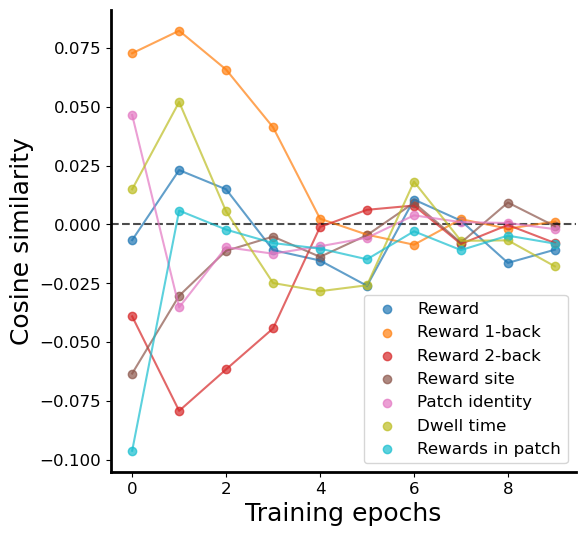

In [173]:
# Initialize plot
plt.figure(figsize=(6, 6))

# Make axis lines thicker
plt.gca().spines["top"].set_linewidth(0)
plt.gca().spines["right"].set_linewidth(0)
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

# Generate 7 distinct colors
colors = plt.cm.tab10(np.linspace(0, 1, 7))

# Generate x values
x_values = np.arange(len(weight_paths))

# Define labels for each line
labels = [
    "Reward",
    "Reward 1-back",
    "Reward 2-back",
    "Reward site",
    "Patch identity",
    "Dwell time",
    "Rewards in patch",
]

# Add a dashed horizontal line at y=0
plt.axhline(y=0, color="black", linestyle="--", linewidth=1.5, alpha=0.7)

# Plot each of the 7 lines distinctly
for i in range(7):
    plt.scatter(
        x_values, cos_sim_reward_int[:, i], 
        color=colors[i], label=labels[i], alpha=0.7
    )
    plt.plot(
        x_values, cos_sim_reward_int[:, i], 
        color=colors[i], linestyle='-', alpha=0.7
    )

# Labels and title with larger font sizes
plt.xlabel("Training epochs", fontsize=18)
plt.ylabel("Cosine similarity", fontsize=18)

# Adjust tick parameters for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust legend to avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc="best", fontsize=12)

# Show the plot
plt.show()

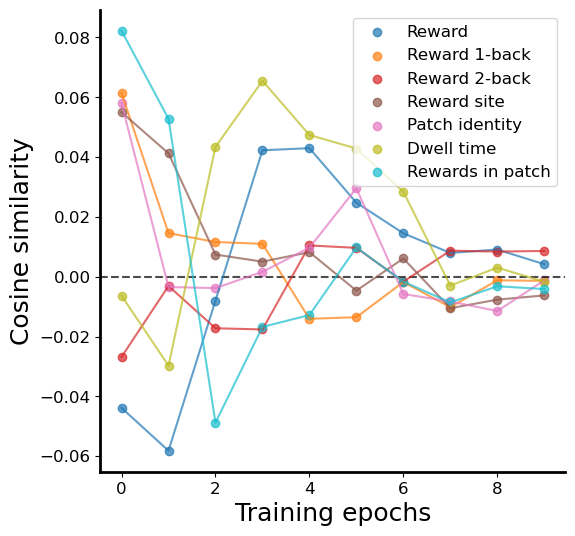

In [174]:
# Initialize plot
plt.figure(figsize=(6, 6))

# Make axis lines thicker
plt.gca().spines["top"].set_linewidth(0)
plt.gca().spines["right"].set_linewidth(0)
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

# Generate 7 distinct colors
colors = plt.cm.tab10(np.linspace(0, 1, 7))

# Generate x values
x_values = np.arange(len(weight_paths))

# Define labels for each line
labels = [
    "Reward",
    "Reward 1-back",
    "Reward 2-back",
    "Reward site",
    "Patch identity",
    "Dwell time",
    "Rewards in patch",
]

# Add a dashed horizontal line at y=0
plt.axhline(y=0, color="black", linestyle="--", linewidth=1.5, alpha=0.7)

# Plot each of the 7 lines distinctly
for i in range(7):
    plt.scatter(
        x_values, cos_sim_reward_reset[:, i], 
        color=colors[i], label=labels[i], alpha=0.7
    )
    plt.plot(
        x_values, cos_sim_reward_reset[:, i], 
        color=colors[i], linestyle='-', alpha=0.7
    )

# Labels and title with larger font sizes
plt.xlabel("Training epochs", fontsize=18)
plt.ylabel("Cosine similarity", fontsize=18)

# Adjust tick parameters for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust legend to avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc="best", fontsize=12)

# Show the plot
plt.show()

In [189]:
pred_accuracy_int = np.empty((len(weight_paths), 11))
pred_accuracy_reset = np.empty((len(weight_paths), 11))

for i, (weight_path, hidden_and_behavior_path) in enumerate(zip(weight_paths, hidden_and_behavior_paths)):
    network = load_network(weight_path)
    hidden_activities, pc_activities, all_session_data = load_hidden_and_behavior(hidden_and_behavior_path)

    integrator_input = np.tensordot(network.proj_to_subnetwork.weight.data[0, :], hidden_activities[:128, :], axes=([0], [0]))[np.newaxis, ...]

    avg_r2, cosine_sim, readout_vecs = get_task_vectors(integrator_input, all_session_data)

    print('integrating input')

    for j in range(len(avg_r2)):
        print(f'r^2 = {avg_r2[j]}, cos sim = {cosine_sim[j]}')

    pred_accuracy_int[i, :] = avg_r2

    reset_input = np.tensordot(network.proj_to_subnetwork.weight.data[1, :], hidden_activities[:128, :], axes=([0], [0]))[np.newaxis, ...]

    avg_r2, cosine_sim, readout_vecs = get_task_vectors(reset_input, all_session_data)

    print('reset input')

    for j in range(len(avg_r2)):
        print(f'r^2 = {avg_r2[j]}, cos sim = {cosine_sim[j]}')

    pred_accuracy_reset[i, :] = avg_r2
        # pred_accaracy_reset[i, j] = cosine(proj_to_subnetwork[1, :], readout_vecs[j, :])

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
(600000, 11)
integrating input
r^2 = 0.010028053653526835, cos sim = 1.0
r^2 = 0.11151310892496054, cos sim = 1.0
r^2 = 0.0605537036382934, cos sim = 1.0
r^2 = 0.12975241505563434, cos sim = 1.0
r^2 = 0.019020883216568186, cos sim = 1.0
r^2 = 0.42029404083124045, cos sim = 1.0
r^2 = 0.00924991438628473, cos sim = 1.0
r^2 = 0.17223531194002106, cos sim = 1.0
r^2 = 0.17609646960637543, cos sim = 1.0
r^2 = 0.5167398567386584, cos sim = 1.0
r^2 = 0.16328642901069995, cos sim = 1.0
(600000, 11)
reset input
r^2 = 0.0743716829404184, cos sim = 1.0
r^2 = 0.11778712055192526, cos sim = 1.0
r^2 = 0.0824943639067673, cos sim = 1.0
r^2 = 0.09080098727602341, cos sim = 1.0
r^2 = 0.014944600232841521, cos sim = 1.0
r^2 = 0.6893569970181936, cos sim = 1.0
r^2 = 0.0005252002086090002, cos sim = 1.0
r^2 = 0.05326431214630227, cos sim = 1.0
r^2 = 0.06443818667890444, cos sim = 1.0
r^2 = 0.42922334814837637, cos sim = 1.0
r^2 = 0.2143846212927218, cos 

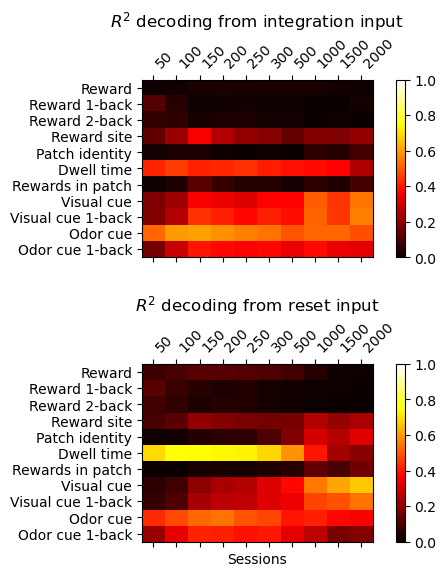

In [199]:
scale = 2  # Adjusted for better visualization
fig, axs = plt.subplots(2, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

cbar = axs[0].matshow(pred_accuracy_int.T, vmin=0, vmax=1, cmap='hot', aspect=0.7)
plt.colorbar(cbar)
cbar = axs[1].matshow(pred_accuracy_reset.T, vmin=0, vmax=1, cmap='hot', aspect=0.7)
plt.colorbar(cbar)

labels = [
    "Reward",
    "Reward 1-back",
    "Reward 2-back",
    "Reward site",
    "Patch identity",
    "Dwell time",
    "Rewards in patch",
    "Visual cue",
    "Visual cue 1-back",
    "Odor cue",
    "Odor cue 1-back",
]

axs[1].set_xlabel('Sessions')
for i in range(2):
    axs[i].set_yticks(np.arange(pred_accuracy_int.T.shape[0]), labels)
    axs[i].tick_params(which='minor', length=0) 
    axs[i].set_xticks(np.arange(pred_accuracy_int.T.shape[1]), list(np.arange(50, 350, 50)) + [500, 1000, 1500, 2000], rotation=45, ha='left')


axs[0].set_title(r'$R^2$ decoding from integration input')
axs[1].set_title(r'$R^2$ decoding from reset input')
fig.subplots_adjust(hspace=0.6)

In [170]:
all_r2_scores = []

for i, hidden_and_behavior_path in enumerate(hidden_and_behavior_paths):
    hidden_activities, pc_activities, all_session_data = load_hidden_and_behavior(hidden_and_behavior_path)
    leave = []
    reward_accumulated = []
    reward_site_indices = []
    odor_nums = []
    for i_s, session_data in enumerate(all_session_data[:30]):
        trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
        
        for k in range(3):
            last_reward_site_idx = None
            last_reward_accumulated_within_patch = None
            last_odor = None
            for i in range(len(trajs_by_patch_type[k])):
                reward_site_idx = session_data['reward_site_idx'][trajs_by_patch_type[k][i]][0]
                if last_reward_site_idx is not None:
                    if last_reward_site_idx >= reward_site_idx:
                        leave.append(True)
                    else:
                        leave.append(False)
                    reward_accumulated.append(last_reward_accumulated_within_patch)
                    reward_site_indices.append(last_reward_site_idx)
                    odor_nums.append(last_odor)
                last_reward_site_idx = reward_site_idx
                last_reward_accumulated_within_patch = session_data['rewards_seen_in_patch'][trajs_by_patch_type[k][i]][-1]
                last_odor = k
        
    leave = np.array(leave)
    reward_site_indices = np.array(reward_site_indices)
    reward_accumulated = np.array(reward_accumulated)
    odor_nums = np.array(odor_nums)

    Y = leave.astype(int)

    X_0 = np.stack([
        odor_nums,
    ]).T

    X_1 = np.stack([
        reward_site_indices,
        odor_nums,
    ]).T

    X_2 = np.stack([
        reward_accumulated,
        odor_nums,
    ]).T

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    avg_r2_scores = []

    ru = RandomUnderSampler()

    for X in [X_0, X_1, X_2]:

        X_ru, Y_ru = ru.fit_resample(X, Y)

        r2_scores = []
        
        for train_idx, test_idx in kf.split(X_ru, Y_ru):
            X_train, X_test = X_ru[train_idx], X_ru[test_idx]
            Y_train, Y_test = Y_ru[train_idx], Y_ru[test_idx]
    
            # Train logistic regression
            model = LogisticRegression(max_iter=5000)
            model.fit(X_train, Y_train)
    
            # Compute score
            r2_scores.append(model.score(X_test, Y_test))

        avg_r2_scores.append(np.mean(r2_scores))

    print(avg_r2_scores)
    all_r2_scores.append(avg_r2_scores)    

        

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
[0.7090559570148984, 0.7055876116816829, 0.7076685737291947]
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
[0.7188752785393755, 0.75989559265991, 0.7264868804103386]
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
[0.6604114161757226, 0.8190693339890484, 0.752440359700033]
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
[0.6909049521376844, 0.8771603942668247, 0.7933598297597203]
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
[0.7014266304347826, 0.9025135869565217, 0.8185461956521738]
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
[0.7014252721873968, 0.899419159335927, 0.8158650817242726]
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
[0.6998736977161105, 0.9246090329792827, 0.8461111314010598]
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
[0.7245778722050787, 0.9357912084952099, 0.8405416843933098]
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
[0.7199129263131423, 0.9298459564460104

Text(0.5, 0, 'Sessions')

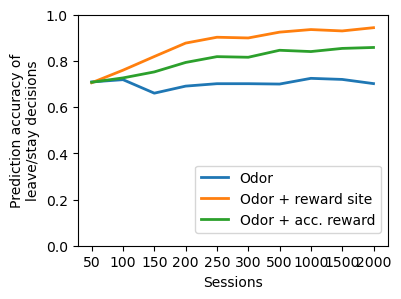

In [171]:
scale = 1  # Adjusted for better visualization
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=False, sharey=True)

r2_arr = np.array(all_r2_scores)

axs.plot(np.arange(r2_arr.shape[0]), r2_arr[:, 0], label='Odor', lw=2)
axs.plot(np.arange(r2_arr.shape[0]), r2_arr[:, 1], label='Odor + reward site', lw=2)
axs.plot(np.arange(r2_arr.shape[0]), r2_arr[:, 2], label='Odor + acc. reward', lw=2)

axs.set_ylim(0, 1)

fig.legend(bbox_to_anchor=(0.9, 0.4))

axs.set_ylabel('Prediction accuracy of\nleave/stay decisions')
axs.set_xticks(np.arange(r2_arr.shape[0]), list(np.arange(50, 350, 50)) + [500, 1000, 1500, 2000])
axs.set_xlabel('Sessions')

Text(0.5, 0, 'Sessions')

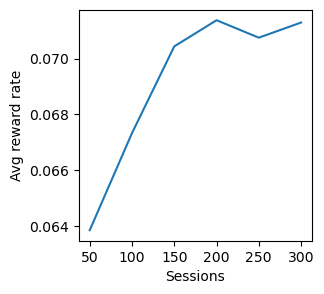

In [117]:
def load_data(data_path, averaging_size=1):
    file_names = glob.glob(data_path)
    data = []
    for file_name in file_names:
        data_for_file = np.load(file_name)
        data.append(data_for_file)
    data = np.concatenate(data, axis=1)
    reduced_data = np.empty((data.shape[0], int(data.shape[1] / averaging_size)))
    for k in range(0, int(data.shape[1] / averaging_size) * averaging_size, averaging_size):
        reduced_data[:, int(k / averaging_size)] = data[:, k:k + averaging_size].mean(axis=1)
    return reduced_data

avg_reward_rates = []
for d_path in hidden_and_behavior_paths:
    averaging_size = 1
    reduced_data = load_data(os.path.join(DATA_BASE_DIR, d_path, 'reward_rates/*.npy'), averaging_size=averaging_size)
    avg_reward_rates.append(reduced_data.mean())

scale = 1  # Adjusted for better visualization
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

axs.plot(np.arange(len(avg_reward_rates)), avg_reward_rates)

axs.set_ylabel('Avg reward rate')
axs.set_xticks(np.arange(r2_arr.shape[0]), np.arange(50, 350, 50))
axs.set_xlabel('Sessions')

In [150]:
avg_reward_rates

[0.06385458333333334,
 0.0673325,
 0.07043958333333333,
 0.07137666666666667,
 0.07075125,
 0.07129416666666666]

In [123]:
print(np.unique(Y, return_counts=True))

(array([0, 1]), array([67774,  5086], dtype=int64))
